## Test a clean install

- conda installs 
- pip jupyter install
- document the .env file

## Restructure

- read.py (interfaces to phonon data)
    - reads in phonon dos data and transforms into an ASE atoms object with dos data stored with the "info" attribute
    - reads in from: materials project API, phonopy output file, ASE phonon object.
    - returns dos_data as a dataframe, and information about the system (e.g. composition)
- analysis.py (manipulate the raw data, physics inspired or to reduce it)
    - system class initialised with ASE atoms object and a pandas 2D dataframe with frequencies and dos.
    - any post-processing / fitting
- sonification.py (strauss)
    - various strauss sonifications initialised with system object
    - parent class can be output to sounddevice or wav file via methods
- main.py (strauss)
    - gets data from read.py
    - uses this to create an system object
    - uses system to create a sonification object
    - use sonification method to output to sounddevice or wav
- app.py
    - Flask app functionality
    - runs main.py

## Implement

- the strauss sonification in the web app

In [1]:
import sounddevice
import numpy as np
import math
import time
import yaml
from scipy import constants

import os
import argparse

phonon_mesh_filepath = './data/BaS_Fm3m/mesh.yaml'
sample_rate = 44100
min_audible = 20# minimum audible frequency in herz
max_audible = 8E3 # maximum audible frequency in herz

In [40]:
def frequencies_from_mp_id(mp_id):
    """return phonon frequencies at gamma point from for a material hosted on the Materials Project ().
    Material is identified using unique ID number. Note that to use this feature you need a Materials
    Project API key (https://materialsproject.org/api)."""
    import mp_api
    from mp_api.client import MPRester
    from dotenv import load_dotenv
    load_dotenv () # use python-dotenv library for storing secrets in a .env file in project route (or at another path that is specified here)

    with MPRester(os.getenv('MP_API_KEY')) as mpr:
        try:
            bs = mpr.get_phonon_bandstructure_by_material_id(mp_id)
        except:
            print("this materials project entry does not appear to have phonon data")
            pass
    return bs
    print("extracting frequencies for qpoint {}".format(bs.qpoints[0].cart_coords))

    phonon_frequencies = list(bs.bands[:,0])
    phonon_frequencies = process_imaginary(phonon_frequencies)
    print("phonon frequencies are (THz):", phonon_frequencies)

    return phonon_frequencies

def dos_from_mp_id(mp_id):
    """return phonon frequencies at gamma point from for a material hosted on the Materials Project ().
    Material is identified using unique ID number. Note that to use this feature you need a Materials
    Project API key (https://materialsproject.org/api)."""
    import mp_api
    from mp_api.client import MPRester
    from dotenv import load_dotenv
    load_dotenv () # use python-dotenv library for storing secrets in a .env file in project route (or at another path that is specified here)

    with MPRester(os.getenv('MP_API_KEY')) as mpr:
        try:
            dos = mpr.get_phonon_dos_by_material_id(mp_id)
        except:
            print("this materials project entry does not appear to have phonon data")
            pass
    freqs = dos.to_pmg.frequencies
    dos = dos.to_pmg.densities

    return freqs, dos

def get_chemical_formula(mp_id):
    """return string containing chemical formula"""
    import mp_api
    from mp_api.client import MPRester
    from dotenv import load_dotenv
    load_dotenv () # use python-dotenv library for storing secrets in a .env file in project route (or at another path that is specified here)

    with MPRester(os.getenv('MP_API_KEY')) as mpr:
        try:
            material_entry = mpr.materials.summary.search(material_ids=mp_id)
        except:
            print("this materials project entry does not seem to exist")
            pass  
    chemical_formulae = material_entry[0].formula_pretty

    return chemical_formulae

In [41]:
f = get_chemical_formula("mp-7548")

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
f

'BaSe3'

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'BaSe3')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

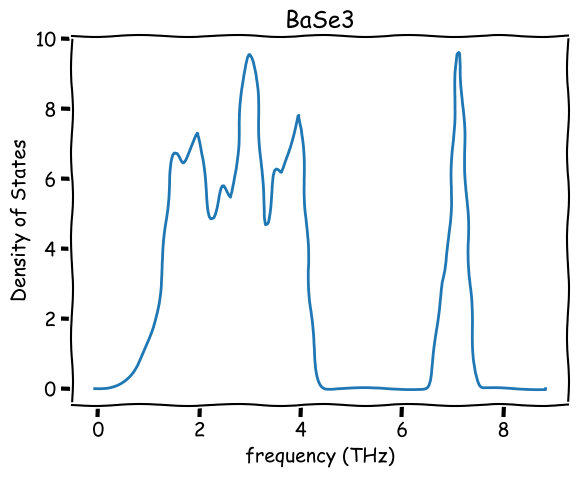

In [43]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

mp_id = "mp-7548"
freq, dos = dos_from_mp_id(mp_id)

plt.xkcd()
plt.plot(freq, dos)
plt.xlabel("frequency (THz)")
plt.ylabel("Density of States")
plt.title(get_chemical_formula(mp_id))


In [10]:
phonon_docs.to_pmg.frequencies

array([-0.07237652, -0.04239728, -0.01241803,  0.01756121,  0.04754046,
        0.07751971,  0.10749895,  0.1374782 ,  0.16745744,  0.19743669,
        0.22741593,  0.25739518,  0.28737443,  0.31735367,  0.34733292,
        0.37731216,  0.40729141,  0.43727066,  0.4672499 ,  0.49722915,
        0.52720839,  0.55718764,  0.58716688,  0.61714613,  0.64712538,
        0.67710462,  0.70708387,  0.73706311,  0.76704236,  0.79702161,
        0.82700085,  0.8569801 ,  0.88695934,  0.91693859,  0.94691783,
        0.97689708,  1.00687633,  1.03685557,  1.06683482,  1.09681406,
        1.12679331,  1.15677255,  1.1867518 ,  1.21673105,  1.24671029,
        1.27668954,  1.30666878,  1.33664803,  1.36662728,  1.39660652,
        1.42658577,  1.45656501,  1.48654426,  1.5165235 ,  1.54650275,
        1.576482  ,  1.60646124,  1.63644049,  1.66641973,  1.69639898,
        1.72637822,  1.75635747,  1.78633672,  1.81631596,  1.84629521,
        1.87627445,  1.9062537 ,  1.93623295,  1.96621219,  1.99

In [ ]:
phonon_docs.to_pmg.

In [13]:
phonon_docs.to_pmg.bands[:,0]

array([0.        , 0.        , 0.        , 1.74501577, 1.76241428,
       1.79155713, 2.27649034, 2.37765811, 2.56556928, 2.66184605,
       2.80429073, 2.90040781, 3.03372632, 3.13715636, 3.34913151,
       3.36353303, 3.51090568, 3.89215787, 3.95236191, 4.34024086,
       6.6999855 , 6.72189244, 7.28162931, 7.31176969])

In [35]:
mpr.materials.phonon.search?

Signature:
mpr.materials.phonon.search(
    material_ids: 'str | list[str] | None' = None,
    num_chunks: 'int | None' = None,
    chunk_size: 'int' = 1000,
    all_fields: 'bool' = True,
    fields: 'list[str] | None' = None,
) -> 'list[PhononBSDOSDoc] | list[dict]'
Docstring:
Query phonon docs using a variety of search criteria.

Arguments:
    material_ids (str, List[str]): A single Material ID string or list of strings
        (e.g., mp-149, [mp-149, mp-13]).
    num_chunks (int): Maximum number of chunks of data to yield. None will yield all possible.
    chunk_size (int): Number of data entries per chunk.
    all_fields (bool): Whether to return all fields in the document. Defaults to True.
    fields (List[str]): List of fields in PhononBSDOSDoc to return data for.
        Default is material_id, last_updated, and formula_pretty if all_fields is False.

Returns:
    ([PhononBSDOSDoc], [dict]) List of phonon documents or dictionaries.
File:      ~/miniconda3/envs/singing-materia

In [27]:
from dotenv import load_dotenv
import os
load_dotenv ()
import mp_api
from mp_api.client import MPRester
mpr = MPRester(os.getenv('MP_API_KEY'))

In [28]:
mpr.materials.phonon.search?

Signature:
mpr.materials.phonon.search(
    material_ids: 'str | list[str] | None' = None,
    num_chunks: 'int | None' = None,
    chunk_size: 'int' = 1000,
    all_fields: 'bool' = True,
    fields: 'list[str] | None' = None,
) -> 'list[PhononBSDOSDoc] | list[dict]'
Docstring:
Query phonon docs using a variety of search criteria.

Arguments:
    material_ids (str, List[str]): A single Material ID string or list of strings
        (e.g., mp-149, [mp-149, mp-13]).
    num_chunks (int): Maximum number of chunks of data to yield. None will yield all possible.
    chunk_size (int): Number of data entries per chunk.
    all_fields (bool): Whether to return all fields in the document. Defaults to True.
    fields (List[str]): List of fields in PhononBSDOSDoc to return data for.
        Default is material_id, last_updated, and formula_pretty if all_fields is False.

Returns:
    ([PhononBSDOSDoc], [dict]) List of phonon documents or dictionaries.
File:      ~/miniconda3/envs/singing-materia